
I have previously shown a [python implementation](https://github.com/bicv/SparseEdges) which allows for the extraction a sparse set of edges from an image:

<BR>
<center><video controls autoplay loop src="../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MPtutorial_rec.mp4" width=61.8%/> </center>
<BR>

* this is exposed in the following book chapter (see also https://laurentperrinet.github.io/publication/perrinet-15-bicv ):

```bibtex
@inbook{Perrinet15bicv,
    title = {Sparse models},
    author = {Perrinet, Laurent U.},
    booktitle = {Biologically-inspired Computer Vision},
    chapter = {13},
    editor = {Keil, Matthias and Crist\'{o}bal, Gabriel and Perrinet, Laurent U.},
    publisher = {Wiley, New-York},
    year = {2015}
}
```

* We were using the raw luminance as the input to the algorithm. What happens if you use [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction)? 
    
* Results : for this particular image, we checked that using the luminance ($\gamma \approx 1$) is the correct choice. This may not be the case for other types of images which would justify an image-by-image local gain control.
    
<!-- TEASER_END -->


# setting up the sparse coding framework

In [1]:
import numpy as np
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
if not mp.pe.do_whitening: print('\!/ Wrong parameters... \!/')
    
# where should we store the data + figures generated by this notebook
import os
mp.pe.do_mask = True
# mp.pe.use_cache = False

mp.pe.N_X, mp.pe.N_Y = 256, 256

mp.pe.N = 1024
#mp.pe.N = 2048
#mp.pe.N = 64
# name = f'/tmp/2019-11-13-B_progressive'
mp.pe.matpath, mp.pe.figpath = '../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit', '../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit'
mp.pe.MP_alpha = 1.
mp.pe.MP_alpha = .8

mp.pe.mask_exponent = 6.
mp = SparseEdges(mp.pe)
mp.init()
print('mp.pe.N_X, mp.pe.N_Y', mp.pe.N_X, mp.pe.N_Y)
# defining input image (get it @ https://www.flickr.com/photos/doug88888/6370387703)
# https://images2.minutemediacdn.com/image/upload/c_crop,h_1286,w_2288,x_0,y_12/v1553818270/shape/mentalfloss/70991-istock-638419754.jpg

print('Default parameters: ', mp.pe)

mp.pe.N_X, mp.pe.N_Y 256 256
Default parameters:  {'verbose': 0, 'N_image': None, 'seed': 42, 'N_X': 256, 'N_Y': 256, 'noise': 0.33, 'do_mask': True, 'mask_exponent': 6.0, 'do_whitening': True, 'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4, 'white_steepness': 4.0, 'white_recompute': False, 'base_levels': 1.618, 'n_theta': 24, 'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N': 1024, 'MP_alpha': 0.8, 'd_width': 45.0, 'd_min': 0.1, 'd_max': 2.0, 'N_r': 6, 'N_Dtheta': 24, 'N_phi': 12, 'N_scale': 5, 'loglevel_max': 7.0, 'edge_mask': False, 'do_rank': False, 'scale_invariant': True, 'multiscale': False, 'kappa_phase': 0.0, 'weight_by_distance': True, 'svm_n_jobs': 1, 'svm_test_size': 0.2, 'N_svm_grid': 32, 'N_svm_cv': 50, 'C_range_begin': -5, 'C_range_end': 10.0, 'gamma_range_begin': -14, 'gamma_range_end': 3, 'svm_KL_m': 0.34, 'svm_tol': 0.001, 'svm_max_iter': -1, 'svm_log': False, 'svm_norm': False, 'figpath'

The useful imports for a nice notebook:

In [2]:
import matplotlib
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)

fig_width = 14

In [3]:
print('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [0.4545 0.2935 0.1895 0.1224 0.079  0.051  0.0329 0.0213 0.0137 0.0089
 0.0057]


In [4]:
print('Range of angles (in degrees): ', mp.theta*180./np.pi)

Range of angles (in degrees):  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


## coding one image

In [5]:
from SLIP import imread
SHOW = False
gamma = 1.

In [6]:
def normalize(image, do_full=False, verbose=SHOW):
    if do_full:
        if verbose: print('in norm', image.mean(), image.min(), image.max())
        image -= image.min()
        if verbose: print('decenter', image.mean(), image.min(), image.max())
        image /= image.max()
        if verbose: print('max out', image.mean(), image.min(), image.max())
    else:
        if verbose: print('in norm', image.mean(), image.min(), image.max())
        image -= image.mean()
        if verbose: print('decenter', image.mean(), image.min(), image.max())
        image /= np.abs(image).max()
        if verbose: print('max out', image.mean(), image.min(), image.max())
        image *= .5
        if verbose: print('max out', image.mean(), image.min(), image.max())
        image += .5
        if verbose: print('recenter', image.mean(), image.min(), image.max())
    return image

def preprocess(image, gamma=gamma, verbose=SHOW):
    if verbose: print('in', image.mean(), image.min(), image.max())
    image = mp.preprocess(image)
    if verbose: print('preproc', image.mean(), image.min(), image.max())
    image = normalize(image)
    if verbose: print('norm', image.mean(), image.min(), image.max())
    image = image**gamma
    if verbose: print('out', image.mean(), image.min(), image.max())
    return image

def deprocess(edges, gamma=gamma, verbose=SHOW):
    
    image = mp.dewhitening(mp.reconstruct(edges))
    image = normalize(image, do_full=False)
    image = image**(1/gamma)
    image = normalize(image, do_full=True)
    
    return image

In [7]:
from SLIP import imread
url = 'https://upload.wikimedia.org/wikipedia/commons/d/d7/Meisje_met_de_parel.jpg'
#url = 'https://farm7.staticflickr.com/6058/6370387703_5e718ea681_q_d.jpg'
image = imread(url)
#image = mp.imread(os.path.join(mp.pe.matpath, '6370387703_5e718ea681_q_d.jpg'))
from skimage.transform import resize
image_original = resize(image, (mp.pe.N_X, mp.pe.N_Y))
print('image shape=', mp.pe.N_X, mp.pe.N_Y, image.shape)


image shape= 256 256 (4794, 4095)


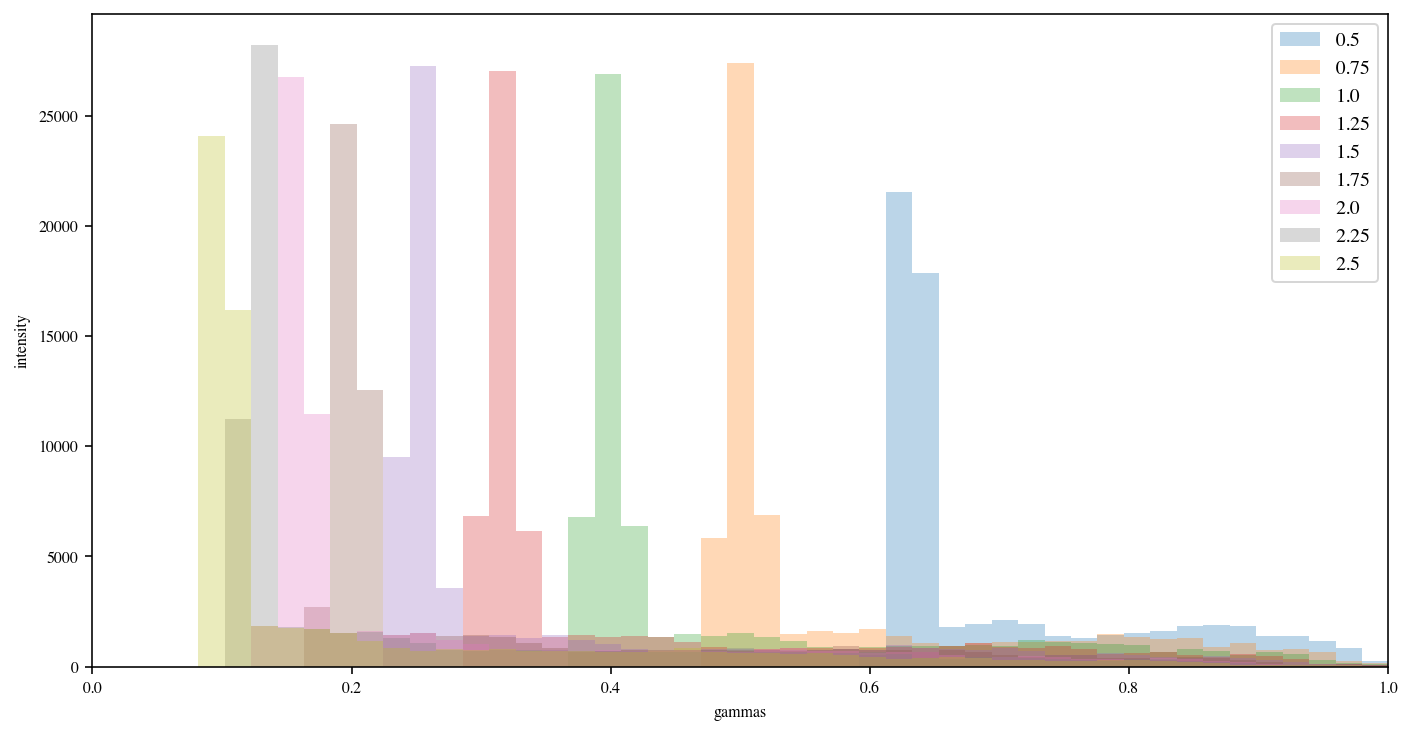

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
gammas = np.linspace(.5, 2.5, 9) # [1.,  2.3]
for gamma in gammas:
    image = image_original.copy()
    image = preprocess(image, gamma=gamma, verbose=False)

    #image = mp.normalize(image)
    ax.hist(image.ravel(), bins=np.linspace(0, 1, 50), alpha=.3, label=gamma)
    
ax.set_xlim([0, 1])
ax.set_xlabel('gammas')
ax.set_ylabel('intensity')       
_ = plt.legend()

Processing one image with different values of gamma:

In [9]:
gammas = np.linspace(.5, 2.5, 9) # [1.,  2.3]
for gamma in gammas:
    name = f'MP_gamma_{gamma}'
    print('processing ', name)
    matname = os.path.join(mp.pe.matpath, name + '.npy')
    image = image_original.copy()
    if mp.pe.do_mask: image = (image-image.mean())*mp.mask + image.mean()
    image = preprocess(image, gamma=gamma)

    image = mp.normalize(image)
    print('norm', image.mean(), image.min(), image.max())
    white = mp.whitening(image)
    #show(image);
    print('white', white.mean(), white.min(), white.max())
    try:
        edges = np.load(matname)
    except:
        edges, C_res = mp.run_mp(white, verbose=True)
        np.save(matname, edges)    

    try:
        edges = np.load(matname)
    except:
        edges, C_res = mp.run_mp(white, verbose=True)
        np.save(matname, edges)    

    matname_MSE = os.path.join(mp.pe.matpath, name + '_MSE.npy')
    matname_SSIM = os.path.join(mp.pe.matpath, name + '_SSIM.npy')
    try:
        MSE = np.load(matname_MSE)
        SSIM = np.load(matname_SSIM)
    except:
        MSE = np.ones(mp.pe.N)
        # https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html
        from skimage.metrics import structural_similarity as ssim
        opts_ssim = dict(multichannel=False, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)

        SSIM = np.ones(mp.pe.N)
        white_rec = np.zeros_like(image)
        for i_N in range(mp.pe.N):
            MSE[i_N] =  ((white-white_rec)**2).sum()
            white_rec += mp.reconstruct(edges[:, i_N][:, np.newaxis])
            image_rec = deprocess(edges[:, :i_N], gamma=gamma)
            SSIM[i_N] =  ssim(image_original, image_rec, data_range=image_rec.max() - image_rec.min())   

        np.save(matname_MSE, MSE)        
        np.save(matname_SSIM, SSIM)         

processing  MP_gamma_0.5
norm 0.043063730512441244 -0.3299204523434332 1.0
white 2.277297483685545e-09 -0.5814991120510308 0.6611745847318196


NameError: name 'do_mask' is not defined

In [ ]:
mp.f

In [ ]:
#edges = np.load(matname)

fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches
mp.pe.figsize_edges = .382 * fig_width  # useful for papers
mp.pe.figsize_edges = 9 # useful in notebooks
mp.pe.line_width = 1.
mp.pe.scale = 1.
fig, a = mp.show_edges(edges, image=image, show_phase=True, show_mask=True)
#mp.savefig(fig, name + '_rec')

A nice property of Matching Pursuit is that one can reconstruct the image from the edges:

In [ ]:
white_rec = mp.reconstruct(edges)
print('remaining energy  = ', ((white-white_rec)**2).sum()/(white**2).sum()*100, '%')

The whitened reconstructed image looks like:

In [ ]:
image_rec = deprocess(edges)
fig, a = mp.show_edges(edges, image=image_rec);

let's check how this varies with gamma:

In [ ]:
MSE_0 = (white**2).sum()

plt.figure(figsize=(12,6))
plt.subplot(111)
for gamma in gammas:
    name = f'MP_gamma={gamma}'
    matname_MSE = os.path.join(mp.pe.matpath, name + '_MSE.npy')
    MSE = np.load(matname_MSE)
    plt.plot(np.sqrt(MSE/MSE[0]), 'o', label=f'gamma={gamma}', alpha=.2)
plt.xlim([0, mp.pe.N])
plt.ylim([0, 1])
plt.xlabel('# atoms')
plt.ylabel('MSE')
_ = plt.legend()

In [ ]:

plt.figure(figsize=(12,6))
plt.subplot(111)
for gamma in gammas:
    name = f'MP_gamma={gamma}'
    matname_SSIM = os.path.join(mp.pe.matpath, name + '_SSIM.npy')
    SSIM = np.load(matname_SSIM)    
    plt.plot(SSIM, 'o', label=name, alpha=.2)
plt.xlim([0, mp.pe.N])
plt.ylim([0, 1])
plt.xlabel('# atoms')
plt.ylabel('SSIM')
_ = plt.legend()

In [ ]:
MSE_0 = (white**2).sum()

fig, axs = plt.subplots(1, 2, figsize=(12,6))
MSEs, SSIMs = [], []
for gamma in gammas:
    name = f'MP_gamma={gamma}'
    matname_MSE = os.path.join(mp.pe.matpath, name + '_MSE.npy')
    MSE = np.load(matname_MSE)
    MSEs.append(MSE[-1])
    matname_SSIM = os.path.join(mp.pe.matpath, name + '_SSIM.npy')
    SSIM = np.load(matname_SSIM)    
    SSIMs.append(SSIM[-1]) 

axs[0].plot(gammas, np.sqrt(MSEs/MSE[0]))
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('gammas')
axs[0].set_ylabel('MSE')
axs[1].plot(gammas, SSIMs)
axs[1].set_ylim([0, 1])
axs[1].set_xlabel('gammas')
axs[1].set_ylabel('SSIM')

## some book keeping for the notebook

In [ ]:
%ls -l ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MP_gamma*MSE*
#%rm ../files/2015-05-22-a-hitchhiker-guide-to-matching-pursuit/MP_gamma*MSE*

In [ ]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,SLIP,LogGabor,SparseEdges,matplotlib  -r -g -b